In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';')
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [3]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


# Проверим, есть ли какие-либо проблемы с группами

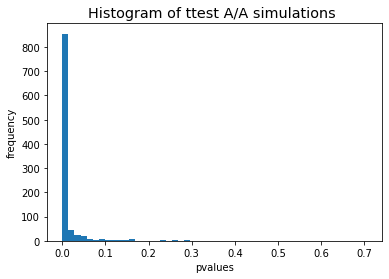

0.937

In [4]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Очевидно, что группы кардинально разные

In [5]:
df.groupby(['experimentVariant', 'version'], as_index = False) \
    .agg({'purchase':'mean', 'uid':'count'})

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Наша догадка в ошибочном разделении подтверждается неравномерностью покупок по версии приложения.
v2.8.0 у 0-ой группы в 45 раз покупок больше, чем у 1-ой группы. Остальные версии +- не отличаются (но все же проверим!)

Проверим сплитование путем исключения всех пользователей с версией приложения v2.8.0

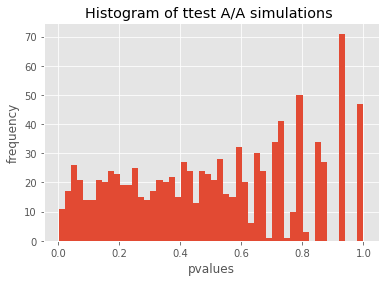

0.042

In [6]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Вот теперь другое дело! Правда, скачкообразные значения в конце не внушают доверия...
Проверим еще версии v3.7.4.0 и v3.8.0.0

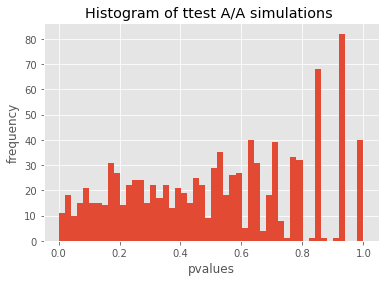

0.031

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

С версией все в порядке, даже полном!

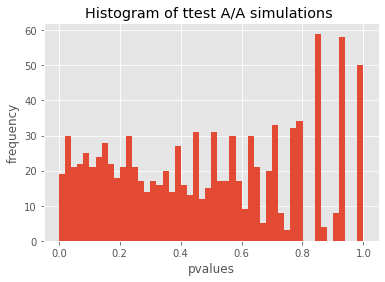

0.06

In [13]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

С версией все в порядке, даже полном!

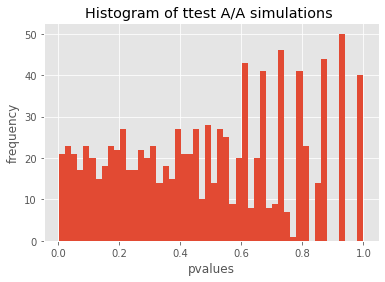

0.053

In [14]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version == 'v2.9.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version == 'v2.9.0')]['purchase'].sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Как мы видим, оставшиеся три версии дают p-значение меньше 0.05 - с ними все в порядке!
Значит, поломка заключена в версии 2.8.0